<a href="https://colab.research.google.com/github/DaverArenas/DeepLearning_ImageClassification/blob/main/Clasificar_GatosPerros_DataGenerator_18_07_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo usando Keras con la base de datos de perros y gatos

Enlace de datos: 
[Descargue la base de datos aquí](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

In [ ]:
from sklearn.datasets import load_files       
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
import os

## Cargando archivos desde Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Como el fichero está comprimido con .zip, se ejecuta la siguiente instrucción para descomprimirlo

In [ ]:
!unzip "/content/drive/MyDrive/Especializacion BigData EIA/AnaliticadeDatosBIBD/DatasetsAnalytics/Gatos_Perros.zip"

Archive:  /content/drive/MyDrive/Especializacion BigData EIA/AnaliticadeDatosBIBD/DatasetsAnalytics/Gatos_Perros.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!unzip "/content/test.zip"
!unzip "/content/train.zip"

In [ ]:
glob.glob('/content/train/*.jpg')

In [ ]:
fnames_train = np.array(glob.glob('/content/train/*.jpg'))
labels_train = np.array([(0 if 'cat' in fname else 1) for fname in fnames_train])

In [ ]:
fnames_train

array(['/content/train/cat.4725.jpg', '/content/train/cat.5414.jpg',
       '/content/train/cat.3727.jpg', ..., '/content/train/dog.11102.jpg',
       '/content/train/cat.4431.jpg', '/content/train/dog.635.jpg'],
      dtype='<U28')

In [ ]:
labels_train

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
np.unique(labels_train,return_counts=True)

(array([0, 1]), array([12500, 12500]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Gatos y Perros')

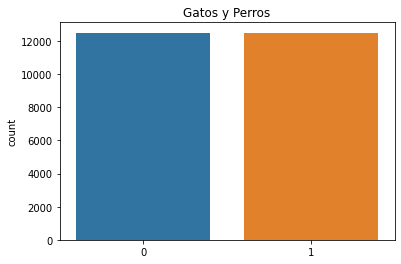

In [ ]:
sns.countplot(labels_train)
plt.title('Gatos y Perros')

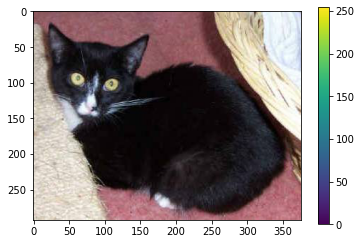

In [ ]:
img = plt.imread(fnames_train[0])
plt.imshow(img)
plt.grid(False)
plt.colorbar()

In [ ]:
img.shape

(293, 376, 3)

Ahora carguemos los datos de prueba

## Creando el conjunto de entrenamiento y prueba
* Necesitamos cargar las imágenes.
* Reescalarlas, porque no tienen el mimo tamaño, por ejemplo acá vamos a ponerlas de 64x64 y con canal 3

### Cargando datos manualmente (Esta opción puede llenar la RAM)

In [ ]:
def read_image(file_path, ROWS = 64,COLS = 64):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS))

In [ ]:
def prep_data(images, ROWS = 64,COLS = 64,CHANNELS=3):
  count = len(images)
  data = np.ndarray((count, ROWS, COLS, CHANNELS))
  for i, image_file in enumerate(images):
    image = read_image(image_file,ROWS,COLS)
    data[i] = image   
  return data

In [ ]:
ROWS = 64
COLS = 64
CHANNELS = 3
#train = prep_data(fnames_train,ROWS=ROWS,COLS=COLS)

In [ ]:
#train.shape

(25000, 64, 64, 3)

In [ ]:
#train=train/255.0

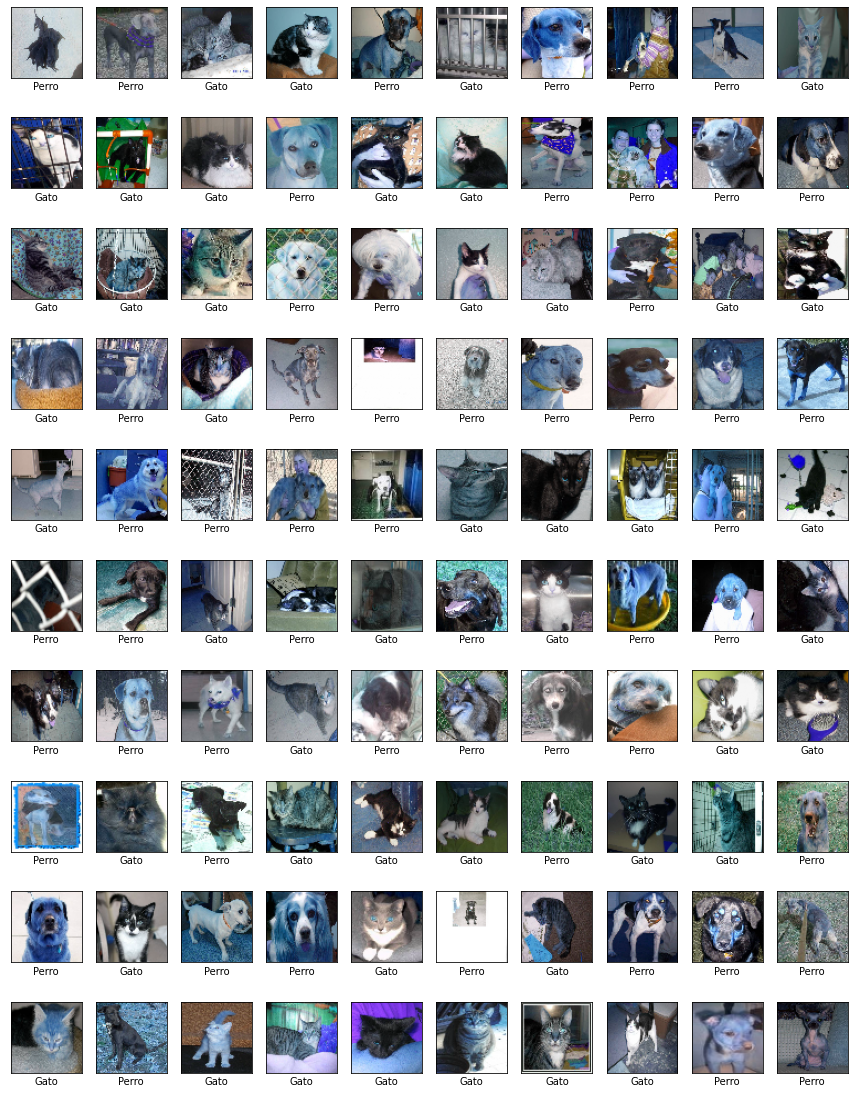

In [ ]:
plt.figure(figsize=(15,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i])
    plt.xlabel('Gato' if labels_train[i]==0 else 'Perro')
plt.show()

### Cargando los datos con ImageDataGenerator

Para cargar los datos con ImageDataGenerator necesitamos tener o los datos separados por carpetas o un Dataframe



In [ ]:
import pandas as pd

In [ ]:
##Necesitamos tener las categorias como tipo string
labels = np.array([('cat' if 'cat' in fname else 'dog') for fname in fnames_train])

In [ ]:
df=pd.DataFrame({'images':fnames_train, 'class':labels})
df

,images,class
0,/content/train/cat.4725.jpg,cat
1,/content/train/cat.5414.jpg,cat
2,/content/train/cat.3727.jpg,cat
3,/content/train/dog.9797.jpg,dog
4,/content/train/dog.10711.jpg,dog
...,...,...
24995,/content/train/cat.4915.jpg,cat
24996,/content/train/dog.8161.jpg,dog
24997,/content/train/dog.11102.jpg,dog
24998,/content/train/cat.4431.jpg,cat


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
##Con esta función tenemos otra forma de cargar los datos. Creamos un objeto con los siguientes parametros. Validation Split parte el dataset (25%)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [ ]:
##Usamos el método flow_from_dataframe para cargar los datos de entrenamiento. shuffle true va aleatorizar los datos
train_generator=datagen.flow_from_dataframe(
dataframe=df,
x_col="images",
y_col="class",
subset="training",
batch_size=64,
seed=5,
shuffle=True,
class_mode='binary',
target_size=(64,64))

Found 18750 validated image filenames belonging to 2 classes.


In [ ]:
##Usamos el método flow_from_dataframe para cargar los datos de validación. shuffle false para NO aleatorizar los datos
validation_generator=datagen.flow_from_dataframe(
dataframe=df,
x_col="images",
y_col="class",
subset="validation",
batch_size=64,
seed=5,
shuffle=False,
class_mode='binary',
target_size=(64,64))

Found 6250 validated image filenames belonging to 2 classes.


## Creando modelo
Definamos el siguiente modelo de red neuronal:

In [ ]:
##(3 , 3) --> filtros de 3x3 generalmente se pone este valor, tiene que ver con el kernel y la operación con la que se va realizar

classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
epochs=10
history = classifier.fit(train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/10
293/293 [==============================] - 72s 202ms/step - loss: 0.6010 - accuracy: 0.6674 - val_loss: 0.5432 - val_accuracy: 0.7256
Epoch 2/10
293/293 [==============================] - 58s 198ms/step - loss: 0.5125 - accuracy: 0.7493 - val_loss: 0.4862 - val_accuracy: 0.7637
Epoch 3/10
293/293 [==============================] - 59s 201ms/step - loss: 0.4586 - accuracy: 0.7850 - val_loss: 0.4605 - val_accuracy: 0.7790
Epoch 4/10
293/293 [==============================] - 59s 200ms/step - loss: 0.4137 - accuracy: 0.8090 - val_loss: 0.4540 - val_accuracy: 0.7922
Epoch 5/10
293/293 [==============================] - 59s 200ms/step - loss: 0.3672 - accuracy: 0.8363 - val_loss: 0.4290 - val_accuracy: 0.7997
Epoch 6/10
293/293 [==============================] - 57s 196ms/step - loss: 0.3252 - accuracy: 0.8581 - val_loss: 0.4440 - val_accuracy: 0.7978
Epoch 7/10
293/293 [==============================] - 58s 199ms/step - loss: 0.2759 - accuracy: 0.8829 - val_loss: 0.4479 - val_ac

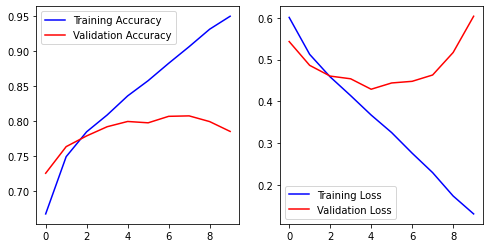

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
predictions=classifier.predict(validation_generator)

In [ ]:
predictions_label=[0 if p<0.5 else 1 for p in predictions]

In [ ]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Para acceder a los labels del conjunto de validación

In [ ]:
labels_test=validation_generator.labels
labels_test

In [ ]:
data_val=validation_generator.filepaths

In [ ]:
predictions_label=[(0 if element<0.5 else 1) for element in predictions]

Text(0.5, 0, 'Perro  1 (Gato)')

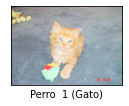

In [ ]:
index_image=10
plt.figure(figsize=(2,2))
plt.grid(False)
plt.xticks([])
plt.yticks([])
im=plt.imread(data_val[index_image])
plt.imshow(im)

predicted_label = "Gato" if predictions[index_image][0]<0.5 else "Perro"
real_label="Gato" if labels_test[index_image]==0 else "Perro"
plt.xlabel("{} {:2.0f} ({})".format(predicted_label,
                              predictions[index_image][0],
                              real_label))

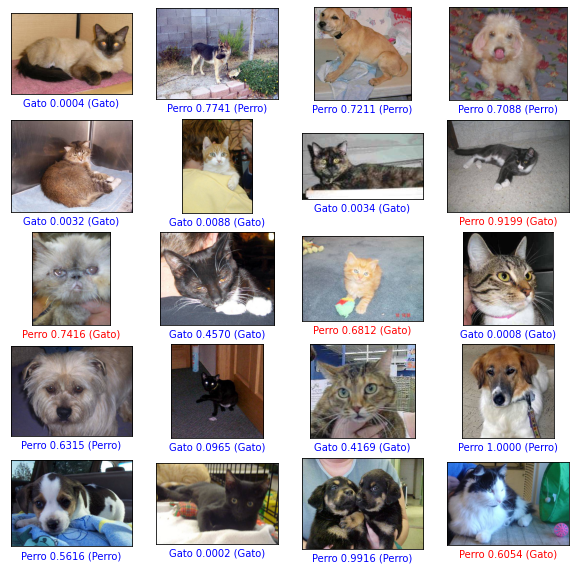

In [ ]:
plt.figure(figsize=(10,10))
for index_image in range(20):
  plt.subplot(5, 4, index_image+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  im=plt.imread(data_val[index_image])
  plt.imshow(im)

  predicted_label = "Gato" if predictions[index_image][0]<0.5 else "Perro"
  real_label="Gato" if labels_test[index_image]==0 else "Perro"
  color= 'blue' if predicted_label == real_label else 'red'
  plt.xlabel("{} {:2.0f} ({})".format(predicted_label,
                                predictions[index_image][0],
                                real_label))
  plt.xlabel(f'{predicted_label} {np.max(predictions[index_image][0]):.4f} ({real_label})', color=color)

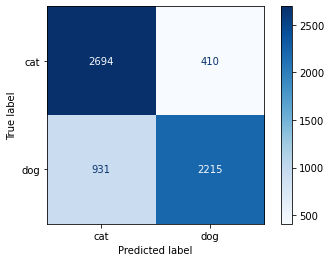

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_test, predictions_label)
cm
train_generator.class_indices
classes=list(train_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
accuracy = np.trace(cm) / float(np.sum(cm))
error = 1 - accuracy
print(accuracy, error)


0.78544 0.21455999999999997


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(labels_test, predictions_label, target_names=classes))

              precision    recall  f1-score   support

         cat       0.74      0.87      0.80      3104
         dog       0.84      0.70      0.77      3146

    accuracy                           0.79      6250
   macro avg       0.79      0.79      0.78      6250
weighted avg       0.79      0.79      0.78      6250



## Un modelo más complejo

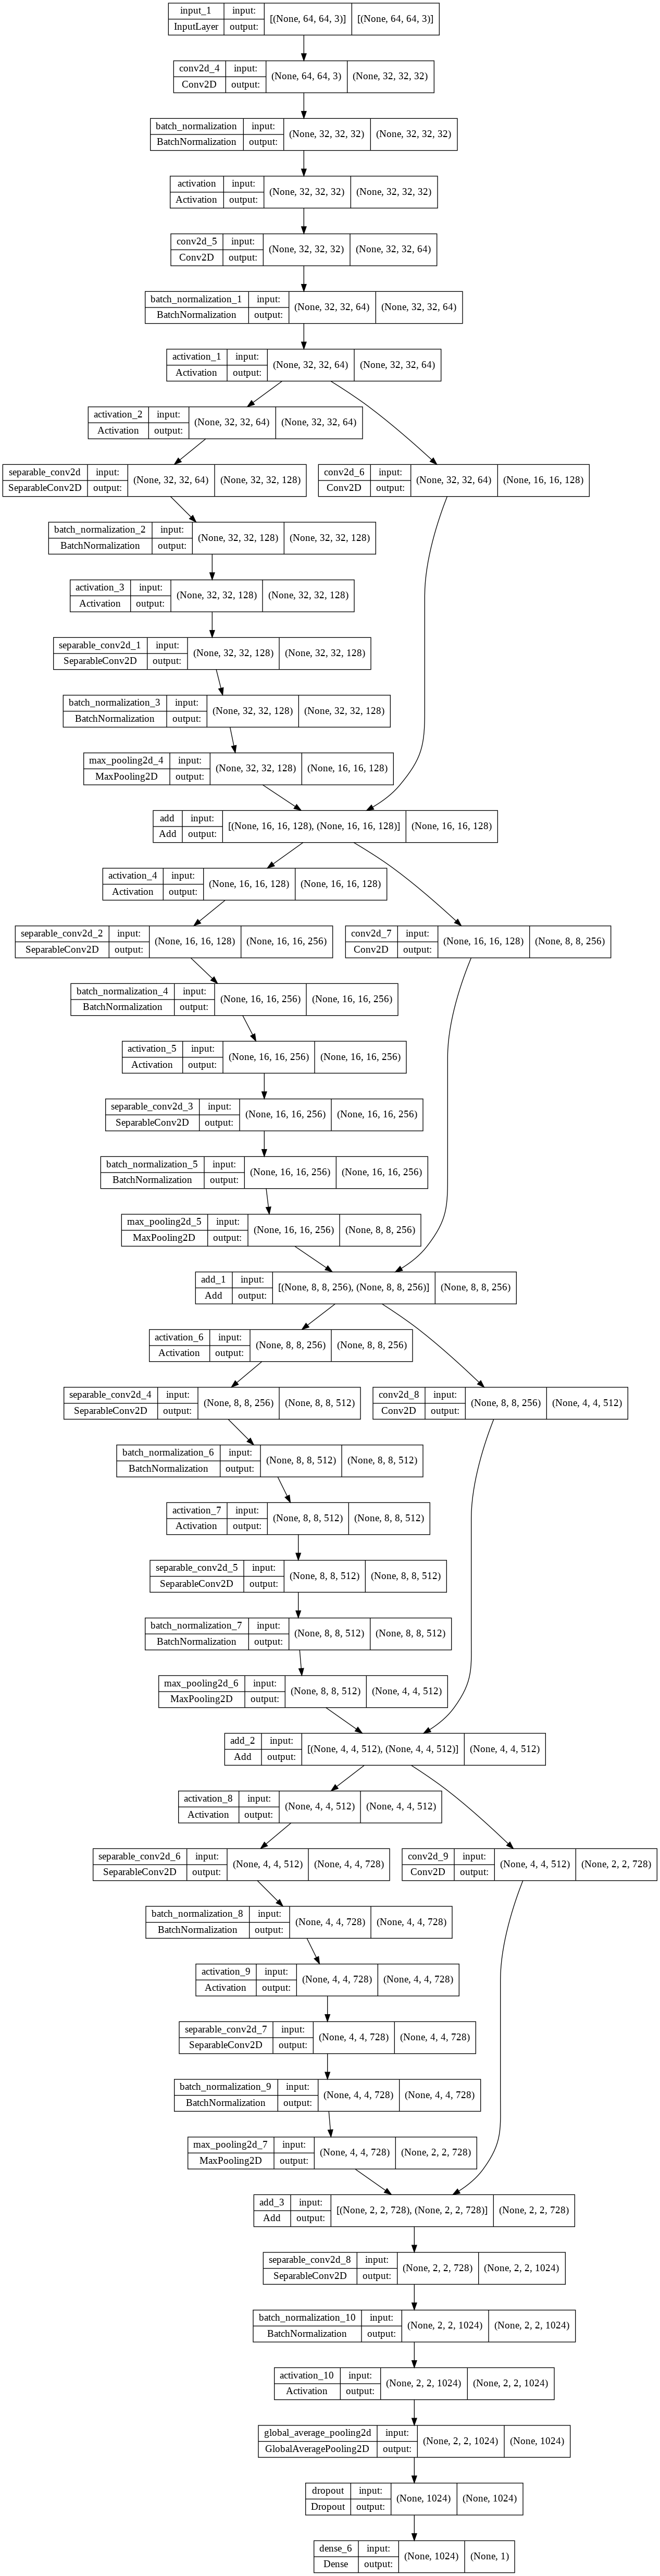

In [ ]:
input_shape=train.shape[1:4]
num_classes=2

inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x 

for size in [128, 256, 512, 728]:
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model= keras.Model(inputs, outputs)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("save_last_model.h5")]
history=model.fit(train_generator, epochs=20, callbacks=callbacks, validation_data=validation_generator)

Epoch 1/20
625/625 [==============================] - 43s 64ms/step - loss: 0.5807 - accuracy: 0.6974 - val_loss: 0.4965 - val_accuracy: 0.7582
Epoch 2/20
625/625 [==============================] - 39s 62ms/step - loss: 0.4126 - accuracy: 0.8129 - val_loss: 0.3892 - val_accuracy: 0.8340
Epoch 3/20
625/625 [==============================] - 38s 61ms/step - loss: 0.3375 - accuracy: 0.8524 - val_loss: 1.7246 - val_accuracy: 0.5588
Epoch 4/20
625/625 [==============================] - 38s 61ms/step - loss: 0.2804 - accuracy: 0.8816 - val_loss: 0.4889 - val_accuracy: 0.7960
Epoch 5/20
625/625 [==============================] - 39s 62ms/step - loss: 0.2348 - accuracy: 0.9036 - val_loss: 0.4033 - val_accuracy: 0.8328
Epoch 6/20
625/625 [==============================] - 38s 61ms/step - loss: 0.1973 - accuracy: 0.9179 - val_loss: 0.3946 - val_accuracy: 0.8376
Epoch 7/20
625/625 [==============================] - 38s 61ms/step - loss: 0.1633 - accuracy: 0.9341 - val_loss: 0.4848 - val_accuracy:

In [ ]:
model.evaluate(validation_generator)

157/157 [==============================] - 3s 17ms/step - loss: 0.5889 - accuracy: 0.8416


[0.5889235734939575, 0.8416000008583069]

## Transferencia de aprendizaje (usando otras redes entrenadas)

Lo mejor para cargar los datos es cargarlo por batch, pero para esto deben estar separadas en carpetas, que no es este caso.

Para separar las imágenes en carpetas con el nombre de las clases, vamos a crear carpetas y dividirlas

In [ ]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Otra opción para separar los datos

In [ ]:
dataset_home = '/content/dataset_dogs_vs_cats/'

labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)

src_directory = '/content/train'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	if file.startswith('cat'):
		dst = dataset_home + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + 'dogs/'  + file
		copyfile(src, dst)

Para poder dividirlo en entrenamiento y validación, vamos a pasarlos con un aleatorio

In [ ]:
dataset_home = '/content/data_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

seed(1)

val_ratio = 0.2
src_directory = '/content/train'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
batch_size=32
train_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/train', class_mode='binary', batch_size=batch_size, target_size=(224, 224))
test_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/test', class_mode='binary', batch_size=batch_size, target_size=(224, 224),shuffle=False)

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
base_modelResNet50=ResNet50(pooling='max', weights='imagenet')

102981632/102967424 [==============================] - 3s 0us/step


In [ ]:
keras.utils.plot_model(base_modelResNet50, show_shapes=True)

In [ ]:
base_modelResNet50.summary()

In [ ]:
base_model=ResNet50(include_top=False, pooling='max', weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
base_model.summary()

In [ ]:
base_model=ResNet50(include_top=False, pooling='max', weights='imagenet')
for layer in base_model.layers:
  layer.trainable = False
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
epochs=5
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/5
623/623 [==============================] - 106s 164ms/step - loss: 0.7355 - accuracy: 0.6284 - val_loss: 0.6303 - val_accuracy: 0.6385
Epoch 2/5
623/623 [==============================] - 100s 160ms/step - loss: 0.6218 - accuracy: 0.6555 - val_loss: 0.6396 - val_accuracy: 0.6328
Epoch 3/5
623/623 [==============================] - 99s 160ms/step - loss: 0.5989 - accuracy: 0.6765 - val_loss: 0.5782 - val_accuracy: 0.6972
Epoch 4/5
623/623 [==============================] - 100s 160ms/step - loss: 0.5912 - accuracy: 0.6823 - val_loss: 0.5701 - val_accuracy: 0.7104
Epoch 5/5
623/623 [==============================] - 100s 160ms/step - loss: 0.5944 - accuracy: 0.6799 - val_loss: 0.6365 - val_accuracy: 0.6297


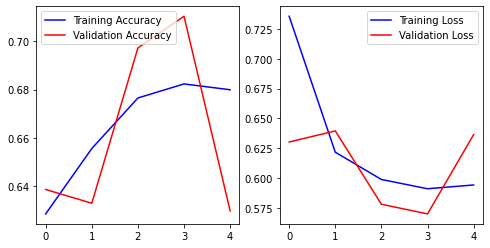

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD

In [ ]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
model.summary()

In [ ]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
##La capa dense recibe vectores, por eso debe tener una capa flatten anterior
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=output)

opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
epochs=10
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=5, verbose=1)

Epoch 1/5
623/623 [==============================] - 139s 217ms/step - loss: 0.2922 - accuracy: 0.8704 - val_loss: 0.3558 - val_accuracy: 0.8363
Epoch 2/5
623/623 [==============================] - 128s 206ms/step - loss: 0.2033 - accuracy: 0.9147 - val_loss: 0.2674 - val_accuracy: 0.8874
Epoch 3/5
623/623 [==============================] - 128s 206ms/step - loss: 0.1801 - accuracy: 0.9257 - val_loss: 0.1657 - val_accuracy: 0.9318
Epoch 4/5
623/623 [==============================] - 128s 205ms/step - loss: 0.1602 - accuracy: 0.9348 - val_loss: 0.1786 - val_accuracy: 0.9210
Epoch 5/5
623/623 [==============================] - 128s 205ms/step - loss: 0.1591 - accuracy: 0.9340 - val_loss: 0.1641 - val_accuracy: 0.9261


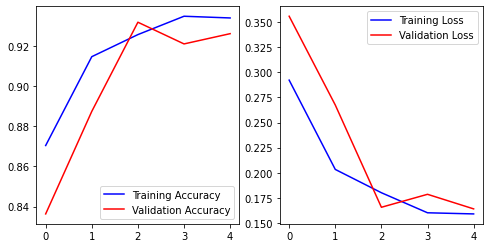

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf', save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf/assets


In [ ]:
model=keras.models.load_model('/content/drive/My Drive/Datos/dogcatsmodels_vgg16.tf')

In [ ]:
## Para una sola imagen
def load_image(filename):
  img = image.load_img(filename, target_size=(224, 224))
  img = image.img_to_array(img)
  img = img.reshape(224, 224, 3)
  img = img.astype('float32')
  return img

In [ ]:
Y_pred = model.predict(test_it)

In [ ]:
predictions_label=[(0 if element<0.5 else 1) for element in Y_pred]

In [ ]:
labels_test=test_it.labels

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_test, predictions_label)
cm

array([[2414,  141],
       [ 184, 2351]])

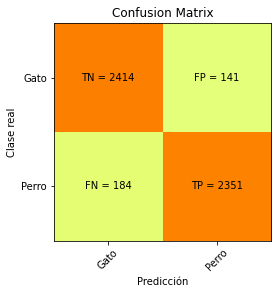

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Gato','Perro']
plt.title('Confusion Matrix')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_test, predictions_label)
cm

array([[2414,  141],
       [ 184, 2351]])

In [ ]:
train_it.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
classes=list(train_it.class_indices.keys())

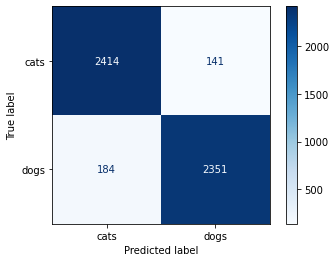

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.inputs, outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=10, verbose=1)

In [ ]:
Y_pred = model.predict(test_it)

In [ ]:
model.evaluate(test_it)

40/40 [==============================] - 52s 1s/step - loss: 0.2077 - accuracy: 0.9126


[0.20769253373146057, 0.9125736951828003]

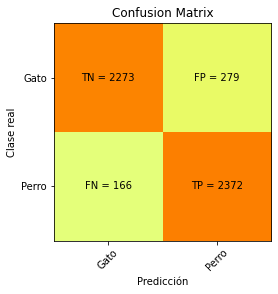

In [ ]:
predictions_label=[(0 if element<0.5 else 1) for element in Y_pred]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_it.labels, predictions_label)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Gato','Perro']
plt.title('Confusion Matrix')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
modelInceptionV3=InceptionV3()
modelInceptionV3.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
batch_size=16
train_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/train', class_mode='binary', batch_size=batch_size, target_size=(299, 299))
test_it = datagen.flow_from_directory('/content/data_dogs_vs_cats/test', class_mode='binary', batch_size=batch_size, target_size=(299, 299),shuffle=False)

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [ ]:
model = InceptionV3(include_top=False, input_shape=(299, 299, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=10, verbose=1)

Epoch 1/10
1245/1245 [==============================] - 286s 223ms/step - loss: 0.4298 - accuracy: 0.9810 - val_loss: 0.1338 - val_accuracy: 0.9892
Epoch 2/10
1245/1245 [==============================] - 272s 219ms/step - loss: 0.1251 - accuracy: 0.9905 - val_loss: 0.0754 - val_accuracy: 0.9927
Epoch 3/10
1245/1245 [==============================] - 273s 219ms/step - loss: 0.0410 - accuracy: 0.9961 - val_loss: 0.1526 - val_accuracy: 0.9906
Epoch 4/10
1245/1245 [==============================] - 273s 219ms/step - loss: 0.0352 - accuracy: 0.9968 - val_loss: 0.1904 - val_accuracy: 0.9921
Epoch 5/10
1245/1245 [==============================] - 274s 220ms/step - loss: 0.0233 - accuracy: 0.9974 - val_loss: 0.1975 - val_accuracy: 0.9933
Epoch 6/10
1245/1245 [==============================] - 273s 220ms/step - loss: 0.0201 - accuracy: 0.9982 - val_loss: 0.1470 - val_accuracy: 0.9929
Epoch 7/10
1245/1245 [==============================] - 274s 220ms/step - loss: 0.0035 - accuracy: 0.9997 - val_

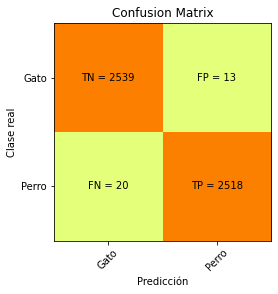

In [ ]:
Y_pred = model.predict(test_it)
predictions_label=[(0 if element<0.5 else 1) for element in Y_pred]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_it.labels, predictions_label)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Gato','Perro']
plt.title('Confusion Matrix')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()